# Xception : Images - Iteration #6 : Data Augementation & Fine Tuning

img_rows = 299 <br>
img_cols = 299 <br>
batch_size = 64 <br>
epochs = 40 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>
Data augmentation  <br>
Fine-tining<br>
Fitting with supposed optimal LR : 0.0004  <br>

**<u>Results</u>**

Accuracy : 0.?? <br>
F1 score weighted : 0.??

#                                           Solving Overfitting

**Import packages**

In [ ]:
from rackuten_project_lib import *

***Read DataFrame from saved pickele file - image Train set***

In [ ]:
#Define Final DF directory 
path = 'D:/DataScienTest_WorkSpace/WS/Travail_Final/Datasets/'

#Directory containing Image Train set
images_dir_train = 'D:/DataScienTest_WorkSpace/WS//data/images/all/image_train/'

#Define output directory  Callback outputs , hdf5 files 
path_output_models = 'D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception/'

#Final DF name 
df_final_name =  'df_train_final.pkl'

In [ ]:
#Read DF file
df_train_im = pd.read_pickle(path + df_final_name)

In [ ]:
df_train_im.head()

In [ ]:
display(df_train_im.shape)

In [ ]:
display(df_train_im.info())

In [ ]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

***Change prdtypecode column to string type***

In [ ]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

 ***Split Train Set***

In [ ]:
X_train_im, X_test_im = train_test_split(df_train_im, train_size = 0.8, random_state = 1234)

In [ ]:
display(X_train_im.shape)
display(X_test_im.shape)

***Data Generator***

In [ ]:
img_rows = 299
img_cols = 299
batch_size = 64
epochs = 40

In [ ]:
%%time
#Data Generator - Train
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  shear_range = 0.2,
                                  rotation_range = 45,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True
                                  #validation_split = 0.2
                                )

In [ ]:
%%time
#Data Generator - Validation
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
%%time

# Data Iterator - Train 
train_generator = train_datagen.flow_from_dataframe(dataframe = X_train_im,
                                              directory = images_dir_train,
                                              #as_ext = True,
                                              x_col = 'image_name',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True  # défault
                                              #subset = 'training'
                                             )

In [ ]:
%%time

# # Data Iterator - Valid 
valid_generator = valid_datagen.flow_from_dataframe(dataframe = X_test_im, 
                                              directory = images_dir_train,
                                              #as_ext = True,
                                              x_col = 'image_name',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False
                                              #subset  = 'validation'
                                             )

 ***Xception Implementation***

In [ ]:
%%time
# Create Xception base model
xception = Xception(weights='imagenet', include_top = False, input_shape=(img_rows, img_cols,3))

# Freeze backbone layers 
for layer in xception.layers:
    layer.trainable = False   

 ***Fine tuning***

In [ ]:
# Unfreeze the last 70 layers of backbone 
for layer in xception.layers[-70:]:
    layer.trainable = True

***Solving Overfitting - Add L2 Regulization & Increase Dropout***

Qu’est-ce que la Regularization ? </br>
Diminution des poids  </br> </br>
La Regularization Weight Decay, en français Diminution des Poids permet d’améliorer la généralisation   </br>
lors de l’apprentissage du modèle.  </br>

De la sorte, le modèle va être performant à la fois sur les données d’entraînements mais aussi sur toutes les autres données. </br>

Comme expliqué dans cet article(https://inside-machinelearning.com/le-deep-learning-cest-quoi/),</br>
lors de l’apprentissage, certaines poids du modèle augmentent tandis que d’autres diminuent. </br></br>

Le but du Weight Decay est de diminuer la valeur des poids trop important.</br></br>

L1 & L2 Regularization</br>
En pratique, la Regularization s’effectue après avoir calculé la loss function. On applique la fonction de régularisation qui :</br></br>

- pour la L1-Regularization la somme des poids en valeur absolue multiplié par une constante α </br>
- pour la L2-Regularization la somme des poids au carré multiplié par une constante α </br>

D'autres outils existent pour contrer l’overfitting</br></br>

- Early stopping</br>
- Data Augmenation</br>
- Dropout</br>
- Batch Normalization</br>


In [ ]:
dropout_rate = 0.4
l1Regu = 0.001
#l2Regu = 0.001

In [ ]:
model = Sequential()
model.add(xception)
# Ajout des couche de classification
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024, activation ='relu', kernel_regularizer = tf.keras.regularizers.L1(l1Regu)))

model.add(Dropout(rate = dropout_rate)) # Before values were rate = 0.2 , 0.3, 0.5  
model.add(Dense(units = 512, activation ='relu', kernel_regularizer = tf.keras.regularizers.L1(l1Regu)))

model.add(Dropout(rate = dropout_rate)) # Before values were rate = 0.2 , 0.3, 0.5 
model.add(Dense(units = 27, activation ='softmax'))
model.summary()

In [ ]:
print("Base_Model length: ", len(xception.layers))
print("Added model length: ", len( model.layers))

print('Last the last ten layers base model - Xception: \n ')  
for layer in xception.layers[-10:]:
    print(layer.name, "  " , layer.trainable)
    
#print('\n Layers of built model: \n')  
#for layer in model.layers:
#    print("", layer.name, "  " , layer.trainable)

***Callbacks***

In [ ]:
# For saving Callbacks and history results
date_result = '26012022'
nbr_Epochs = epochs
learning_rate = 0.0004 
#dropout_rate = 0.4
#l2Regu = 0.001

In [ ]:
%%time

chek_file_name = 'checkpoint_Xception_' + date_result + '_Shape_299x299_' +'LR_'+str(learning_rate)+'_'  \
                 +'dropout_rate_' + str(dropout_rate) + '_l1Regu_' + str(l1Regu) +'_'\
                 +str(nbr_Epochs)+  'Epochs.h5'
    

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path_output_models + chek_file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', 
                             save_freq='epoch')

#Arrêter l'entraînement si le modèle n'évolue plus 

early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 3, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')

#lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
#                              patience = 10,
#                               verbose = 1,
#                               mode='min'
#                              )

 ***Compilation***

In [ ]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer= Adam(learning_rate = learning_rate) ,   #default lr = 0.001 # algorithme de descente de gradient
              metrics=['accuracy'])                    # métrique d'évaluation

 ***Fit - train_generator***

In [ ]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

In [83]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks=[checkpoint, early]                    
                    )

1061/1061 [==============================] - ETA: 0s - loss: 6.3363 - accuracy: 0.4537
Epoch 00001: val_accuracy improved from -inf to 0.52040, saving model to D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception\checkpoint_Xception_26012022_Shape_299x299_LR_0.0004_dropout_rate_0.4_l1Regu_0.001_40Epochs.h5


C:\Users\MME\anaconda3\envs\datascientestEnv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1061/1061 [==============================] - 1312s 1s/step - loss: 6.3363 - accuracy: 0.4537 - val_loss: 2.1303 - val_accuracy: 0.5204
Epoch 2/40
1061/1061 [==============================] - ETA: 0s - loss: 2.1223 - accuracy: 0.5287
Epoch 00002: val_accuracy improved from 0.52040 to 0.57942, saving model to D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception\checkpoint_Xception_26012022_Shape_299x299_LR_0.0004_dropout_rate_0.4_l1Regu_0.001_40Epochs.h5
1061/1061 [==============================] - 1220s 1s/step - loss: 2.1223 - accuracy: 0.5287 - val_loss: 1.8914 - val_accuracy: 0.5794
Epoch 3/40
1061/1061 [==============================] - ETA: 0s - loss: 1.9478 - accuracy: 0.5717
Epoch 00003: val_accuracy improved from 0.57942 to 0.59876, saving model to D:/DataScienTest_WorkSpace/WS/Travail_Final/Trained_models/Xception\checkpoint_Xception_26012022_Shape_299x299_LR_0.0004_dropout_rate_0.4_l1Regu_0.001_40Epochs.h5
1061/1061 [==============================] - 1223s 1s/st

***Plot Model loss , accuracy per epoch***

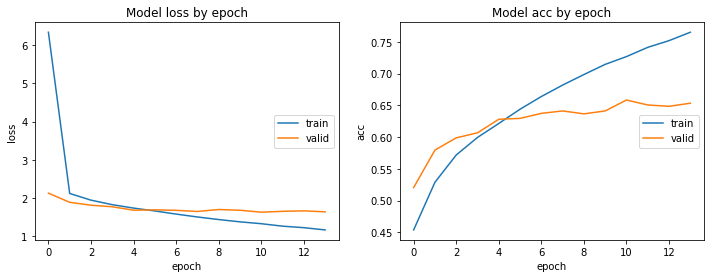

In [84]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

 ***Evaluate - test_generator***

In [85]:
%%time
#Get the accuracy score
valid_score = model.evaluate(valid_generator)
print("[INFO] Model metrics names:", model.metrics_names)
print("[INFO] Accuracy: {:.2f}%".format(valid_score[1] * 100)) 
print("[INFO] Loss: ",valid_score[0])
sc = valid_score[0]

266/266 [==============================] - 71s 267ms/step - loss: 1.6338 - accuracy: 0.6583
[INFO] Model metrics names: ['loss', 'accuracy']
[INFO] Accuracy: 65.83%
[INFO] Loss:  1.633788824081421
Wall time: 1min 11s


 ***Prediction - test_generator***

In [86]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from test generator
y_true = valid_generator.classes

Wall time: 1min 9s


In [87]:
f1_macro = f1_score(y_true, y_pred_class, average='macro')
print("[INFO] f1 score macro average: ",f1_macro)
f1_micro = f1_score(y_true, y_pred_class, average='micro')
print("[INFO] f1 score micro average: ",f1_micro)
f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
print("[INFO] f1 score weighted average: ",f1_weighted)

[INFO] f1 score macro average:  0.6047082593764139
[INFO] f1 score micro average:  0.6582666038624588
[INFO] f1 score weighted average:  0.6523978456345025


***Classification_report***

In [88]:
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       643
           1       0.65      0.65      0.65       503
           2       0.81      0.49      0.61       162
           3       0.43      0.52      0.47       514
           4       0.56      0.43      0.48       664
           5       0.51      0.62      0.56       993
           6       0.76      0.86      0.80       832
           7       0.88      0.51      0.65       159
           8       0.53      0.58      0.55       970
           9       0.72      0.17      0.28       190
          10       0.68      0.85      0.76       911
          11       0.73      0.68      0.70       961
          12       0.36      0.41      0.39       319
          13       0.68      0.60      0.64       301
          14       0.65      0.73      0.69      1011
          15       0.53      0.36      0.43       533
          16       0.84      0.86      0.85      2083
          17       0.50    

***Confusion Matrix***

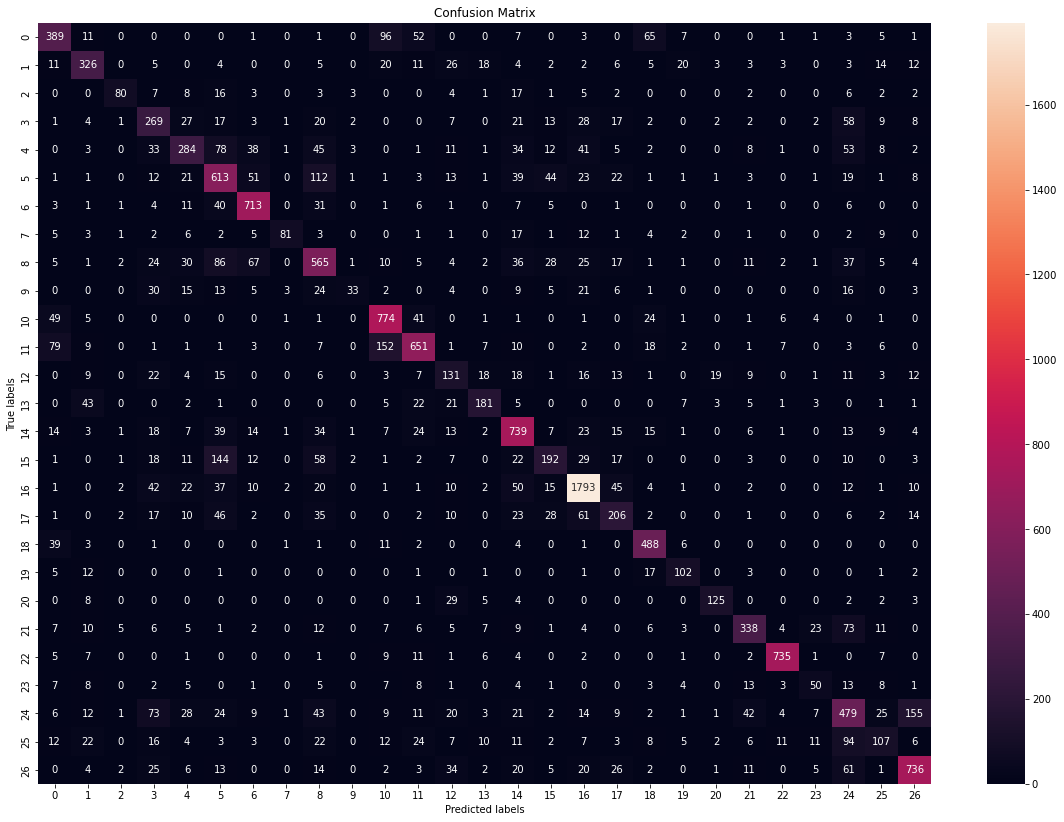

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(20,14))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

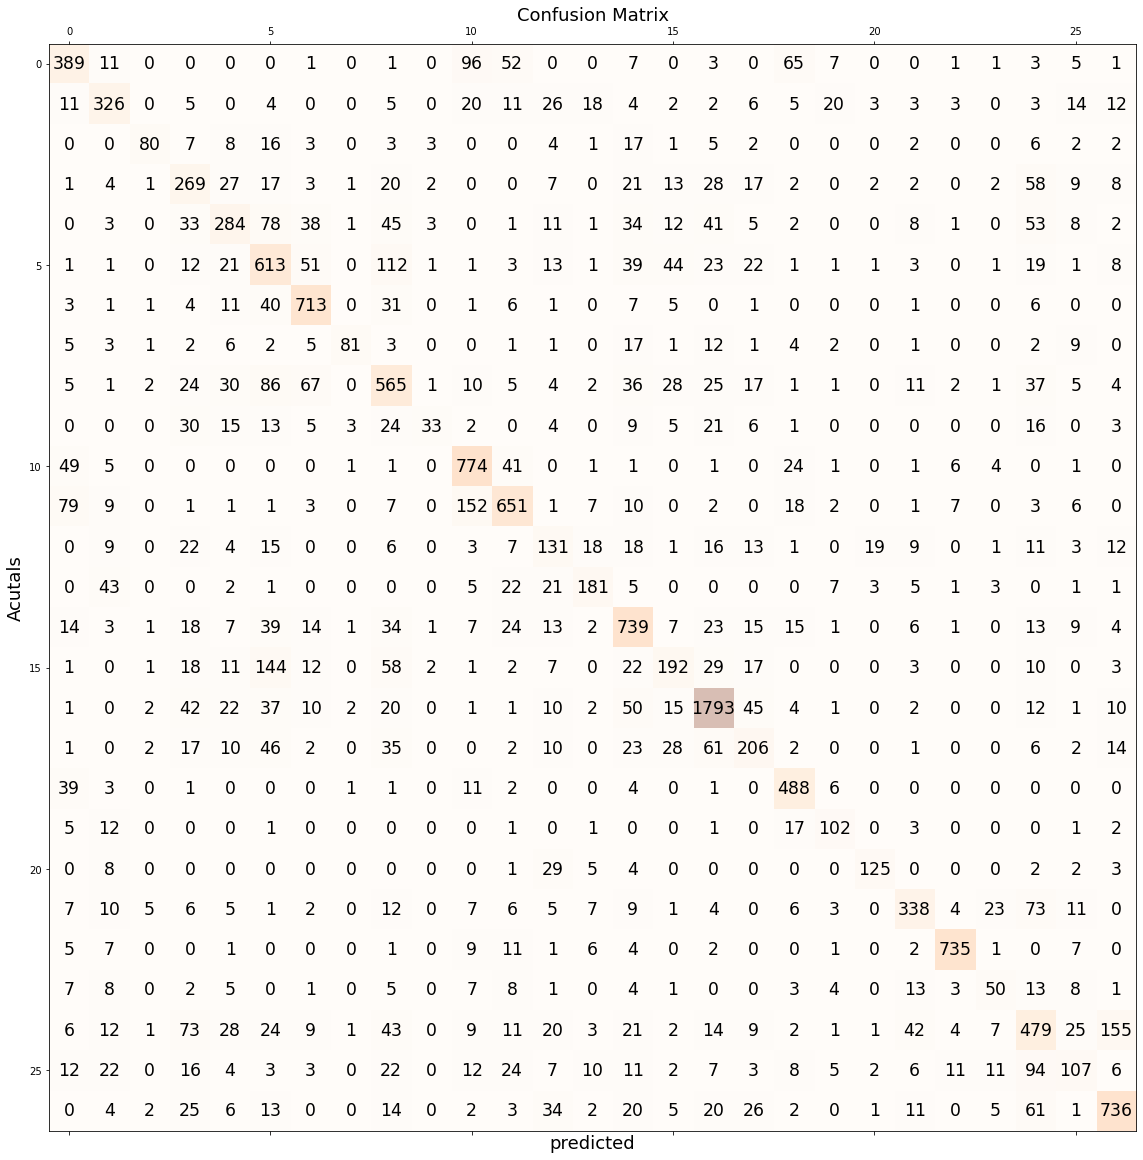

In [90]:
#Confusion matrix

matrix = confusion_matrix(y_true, y_pred_class)
fig , ax = plt.subplots(figsize = (24,20))
ax.matshow(matrix, cmap = plt.cm.Oranges , alpha = 0.3)
for i in range(matrix.shape[0]):
    for j in range (matrix.shape[1]):
        ax.text (x = j , y= i, s= matrix[i,j], va = 'center', ha = 'center', size = 'xx-large')
        
plt.xlabel('predicted', fontsize = 18)
plt.ylabel('Acutals', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()
#print(matrix)

 ***Example of Prediction of single Image***

image file name :  image_1216404223_product_3397499315.jpg


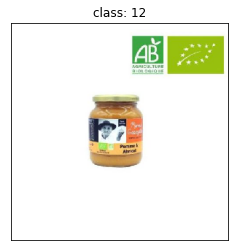

In [91]:
# Predict With Pre Trained

# Load an image
row_id = 230
#img_path ='./data/images/all/image_train_resized/'+ df_train_im['imagePath'][im_id]
img_path =images_dir_train + df_train_im['image_name'][row_id]
print('image file name : ',df_train_im['image_name'][row_id])
img = image.load_img(img_path,target_size=(299, 299))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][row_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [92]:
im = cv2.resize(cv2.imread(img_path), (299, 299))
im = im/255
im = np.expand_dims(im, axis=0)
out = model.predict(im)
im_pred= np.argmax(out)

In [93]:
def get_real_class(val):
    for real_cls, gen_label in valid_generator.class_indices.items():
         if val == gen_label:
            return int(real_cls)

    return "class doesn't exist"

In [94]:
print("------------------Predicted Class and Label ------------------------------")
print("Predicted Data Generator Label :", im_pred,', Corresponds to Real Class Number: ',get_real_class(im_pred) )
print("Predicted Label"  ,df_train_im[df_train_im['prdtypecode'] == str(get_real_class(im_pred))][['labels']].head(1).to_string(index=False)) 

------------------Predicted Class and Label ------------------------------
Predicted Data Generator Label : 16 , Corresponds to Real Class Number:  23
Predicted Label      labels
piscine spa


In [95]:
print("------------------Real Class and Label ------------------------------")
print("Real Class Number: ",df_train_im.loc[[row_id], :]['prdtypecode'].to_string(index=False)  )
print("Real Label: "  ,df_train_im.loc[[row_id], :]['labels'].to_string(index=False)) 

------------------Real Class and Label ------------------------------
Real Class Number:  12
Real Label:  early childhood


 ***Save results:  Model and Training history***

In [96]:
hist_filename = 'history_Xception_' + date_result + '_Shape_299x299_' +'LR_'+str(learning_rate)+'_'  \
                 +'dropout_rate_' + str(dropout_rate) + '_l1Regu_' + str(l1Regu) +'_'\
                 +str(nbr_Epochs)+  'Epochs.h5'    

In [97]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path_output_models + hist_filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path_output_models + hist_filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path_output_models + hist_filename +'.pkl')

In [98]:
file_name = 'Model_Xception_' + date_result + '_Shape_299x299_' +'LR_'+str(learning_rate)+'_'  \
                 +'dropout_rate_' + str(dropout_rate) + '_l1Regu_' + str(l1Regu) +'_'\
                 +str(nbr_Epochs)+  'Epochs.h5' 

In [100]:
#Enregistrement du modèle
model.save(path_output_models + file_name)

***Load Previously saved Xception Model***

In [ ]:
#Rechargement du modèle :
#model = load_model("hdf5 file path")